# Micrograd

In this notebook the backpropagation algorithm is implemented and visualized from scratch in order to understand backpropagation on the deepest level.

In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def f(x):
    return 3*x**2 - 4*x +5

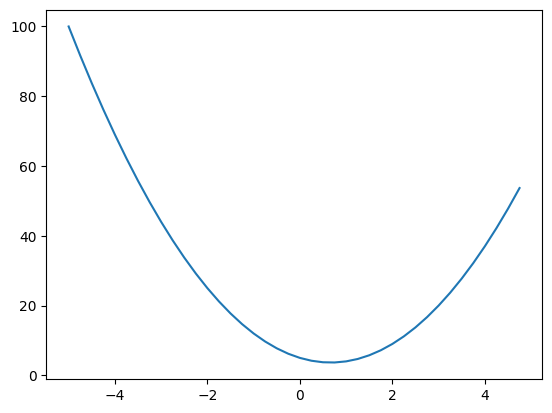

In [41]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [42]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [43]:
a = 2.0
b = -3.0
c = 10.0
d= a*b + c
print(d)

4.0


In [44]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('f1', d1)
print('f2', d2)
print('slope', (d2-d1)/h)
import inspect

f1 4.0
f2 4.0001
slope 0.9999999999976694


#### Parameter Class

Backpropagation is an algorithm that can be used to optimize a set of parameters $\mathbf{p}$ to minimize a loss function $L$. The loss is calculated by infering data samples and comparing the output with the respective targets. In order to minimize the loss function, stochastic gradient descent is applied, i.e. the parameters are updated based on their derivative with respect to the loss. 

In the following cell, the class of a parameter is presented. A parameter can be anything - a weight in a weights matrix, a bias in a bias vector or a any parameter of a mathematical system. The important part is, that a parameter is not only represented by a numerical value, but also by other attributes, which are defined in the ```__init__()``` method:
- ```data``` - numerical value of $p$
- ```grad``` - numerical value of the gradient of the loss with respect to this parameter, i.e. $\frac{dL}{dp}$
- ```_backward``` - function which calculates the gradient of each operand in a binary operation like addition, multiplication, ...
- ```_prev``` - stores the two parameters which were used to create the current parameter
- ```_op``` - stores the operation which was used to create the current parameter
- ```label``` - a label for each parameter for visualization purposes

In [45]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

#### Representation

First the python internal method of representing a class is overwritten. This way one can easily see the numerical value associated with this parameter

In [46]:
def __repr__(self):
    return f"Value(data={self.data})"

Value.__repr__ = __repr__

#### Addition

Let's say we have $c=a+b$, and the parameter we are inspecting is $a$. First we have to check the other summand $b$. If it also is a parameter, then everything is fine, however if it is a constant value, we need to convert it to a parameter as well, in order for every function to work properly. Keep in mind that if we transform the constant into a parameter with ```other = Value(other)```, the gradient of ```other``` is set to zero and only the ```data``` attribute is initialized.

The result of an addition is trivial: $c=a+b$, therefore ```out``` is just a new parameter, where the numerical values of each summand are added. The children ```self``` and ```other``` are added to the set and the operation ```+``` is specified.

For the ```_backward()``` method, a small explanation is provided. If we have a function $L(x,y)$ and we want the derivative of this function with respect to a parameter $x$ which is in turn part of a function $y(x)$, the **chain-rule** can be applied: $\frac{dL}{dx} = \frac{dL}{dy} * \frac{dy}{dx}$. Because we have a backward pass and $\frac{dL}{dL} = 1$, we always know the gradient of the result of the operation. I.e. if $c=a+b$ the gradient $\frac{dL}{dc}$ is already known. Therefore in order to get $\frac{dL}{dx}$, we only need to calculate $\frac{dy}{dx}$ and multipy with the gradient of the result.

Back to the $c=a+b$ example. First $\frac{dc}{da}= 1.0$  and $\frac{dc}{db}= 1.0$. This means that in an addition, the gradient of the result is just **propagated backwards**. Note that the gradients are added using the ```+=``` operator. This is because when $L(x,y,z)$ and $y=y(x)$ and $z=z(x)$, which means that $x$ influences $y$ and $z$, the gradient $\frac{dL}{dx}$ is the sum of its influences, i.e. the sum of the gradients $\frac{dL}{dy}*\frac{dy}{dx}$ and $\frac{dL}{dz}*\frac{dz}{dx}$. Just imagine $c=a(x)+b(x) = 2x + 3x$, then $\frac{dc}{dx} = \frac{dc}{da}*\frac{da}{dx} + \frac{dc}{db}*\frac{db}{dx} = 1.0 * 2.0 + 1.0 * 3.0$.  You can read more if you google "multivariate chain rule". Finally the ```_backward()``` method is assigned to the output value, which can now calcualte the gradients of its childred.

In [47]:
def __add__(self, other):
    print(f"Function {inspect.currentframe().f_code.co_name} invoked")
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
        self.grad += 1.0 * out.grad 
        other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

Value.__add__ = __add__

There is an extra case which we have to consider in addition. When Python evaluates an addition ```c = a + b``` the serialized commands look something like this: ```c = a.__add__(b)```. If a is from the class Value and ```b``` is a constant, everything is fine, as we have checked before. But what if the operation is $c= b + a$? In our head we can calcuate this straightforward, but Python would call ```c = b.__add__(a)```. If ```b``` is a constant, it does not have the custom ```__add__()``` method implemented and an error will appear. Therefore we need to implement the ```__radd__()``` method, which is used by Python in the case that the left hand side does not have the ```__add__()``` method implemented. Python then checks if the right hand side of the addition implemented the ```__radd__()``` method. This fallback method changes the order of the addition and we can add both parameters like before. In particular, if $c=b+a$ and $a$ is a parameter and $b$ not, python first checks if $b$ has the addition method implemented and if not, check if $a$ has the fallback method implemented. The fallback method will be called on $a$, and if ```self + other``` is returned, the fallback additon is now $c = a + b$, because a is self and b is other.

In [56]:
def __radd__(self, other): # other + self
    print(f"Function {inspect.currentframe().f_code.co_name} invoked")
    return self + other

Value.__radd__ = __radd__

Here are both cases with the sequence of functions invoked displayed:

Normal case:
![Alt text](images/img2.png "Optional title")

Reversed case:
![Alt text](images/img1.png "Optional title")




In [57]:
a = Value(2.0)
b = 3.0
c = a + b
print("c =", c)

Function __add__ invoked
c = Value(data=5.0)


In [1]:








    def __rmul__(self, other):  # for the case constant*Value and not Value*constant
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        return self * other

    def __mul__(self, other):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        return self * other**-1

    def __neg__(self):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        return self * -1

    def __sub__(self, other):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        return self + (-other)
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def exp(self):
#        print(f"Function {inspect.currentframe().f_code.co_name} invoked")
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        # Builds a topological graph, where all the arrows go in one direction
        # Therefore a node always has all of its dependencies already calculated
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'

In [8]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [11]:
L._op

'*'

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

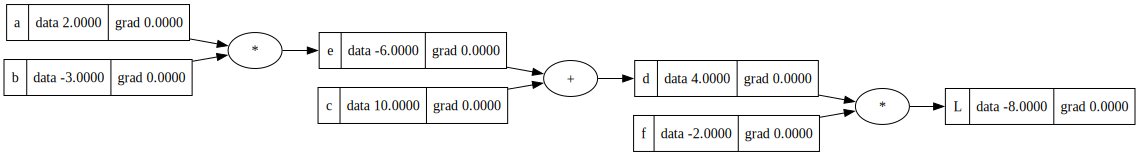

In [25]:
draw_dot(L)

In [119]:
def lol():

    h =  0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

0.0


In [120]:
L.grad = 1.0

L = d * f 

= (e + c) * f

= ((a * b) + c)) * f

dL/dc = f

In [121]:
# Just remember derivatives
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0 * 1
e.grad = -2.0 * 1
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [122]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

Value(data=0.7071067811865476)
Value(data=0.8813735870195432)
Value(data=6.881373587019543)
Value(data=-6.0)
Value(data=-6.0)
Value(data=-3.0)
Value(data=2.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)


Last time stamp: 1:09

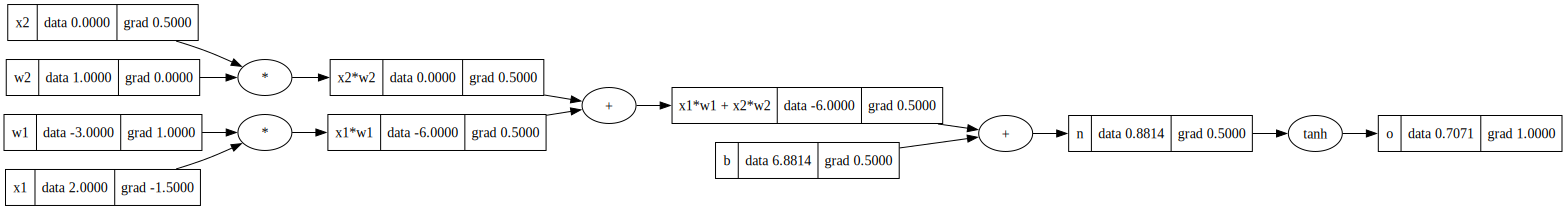

In [123]:
draw_dot(o)

In [124]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

Value(data=0.7071067811865477)
Value(data=0.1464466094067262)
Value(data=6.828427124746192)
Value(data=5.828427124746192)
Value(data=1.7627471740390863)
Value(data=2)
Value(data=0.8813735870195432)
Value(data=-6.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=6.881373587019543)
Value(data=1)
Value(data=4.828427124746192)
Value(data=-1)


In [125]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [126]:
x2.grad.item()

0.5000001283844369

In [106]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.835519661773241)

In [107]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [108]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero grad
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data+= -0.05 * p.grad

    print(k, loss.data)
    

0 3.8057929007555784
1 1.4740512940756618
2 0.3860607521698658
3 0.23088522983402304
4 0.17259745684458022
5 0.13714292822892862
6 0.113323778231324
7 0.09627962294356843
8 0.08351646717431421
9 0.07362319250065803
10 0.06574315848283874
11 0.05932730502064307
12 0.05400808276179854
13 0.0495305186699332
14 0.04571238440943677
15 0.042420105386055805
16 0.03955361791708466
17 0.03703653197468119
18 0.0348095555482525
19 0.03282598806276683


In [109]:
ypred

[Value(data=0.9465647238632354),
 Value(data=-0.9117858661351046),
 Value(data=-0.9022799115589097),
 Value(data=0.8875735341279183)]